In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from dpt.plmodels import InteriorNetDPT
from data.InteriorNetDataset import InteriorNetDataset
from data.metrics import SILog, DepthMetrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device name: {torch.cuda.get_device_name(0) if device != "cpu" else "cpu"}')

device name: A40


In [3]:
# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'
logs_path = 'train-logs'

# checkpoint_name = 'version_233' # intel-impl2

# checkpoint_name = 'version_230' # intel-impl

checkpoint_name = 'version_218' # base version
# checkpoint_name = 'version_234'

if k8s:
    model_path = os.path.join(k8s_pvc, 'dpt-hybrid-nyu.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)
    logs_path = os.path.join(k8s_pvc, logs_path)
    
    checkpoint_dir = os.path.join(logs_path, 'finetune', checkpoint_name, 'checkpoints')
    
    os.chdir('/')

In [4]:
# select a checkpoint path based on the ones available
ckpts = os.listdir(checkpoint_dir)
sorted(ckpts, key=lambda x: int(re.findall(r'\d+', x)[0]))

['dpt-finetune-epoch=4.ckpt', 'dpt-finetune-epoch=9.ckpt']

In [5]:
chosen_ckpt = ckpts[0]
checkpoint_path = os.path.join(checkpoint_dir, chosen_ckpt)

In [6]:
model = InteriorNetDPT(batch_size=1, 
                       lr=0, 
                       num_epochs=0, 
                       model_path=checkpoint_path)

model.to(device)
model.freeze()

In [7]:
dataset = InteriorNetDataset(dataset_path, split='val', 
                             transform='default', no_folds=True)

loader = DataLoader(dataset, batch_size=model.hparams.batch_size)

metrics = DepthMetrics()

epoch_num = re.findall(r'\d+', chosen_ckpt)[0]
if f'st-{epoch_num}.pt' in os.listdir(os.path.dirname(checkpoint_dir)):
    st = torch.load(os.path.join(os.path.dirname(checkpoint_dir), f'st-{epoch_num}.pt'))
    if st['s'][0].numel() == 1:
        s,t = torch.tensor(st['s']).mean(0), torch.tensor(st['t']).mean(0)
    else:
        s,t = torch.cat(st['s']).reshape(-1, *list(st['s'][0].shape)), torch.cat(st['t']).reshape(-1, *list(st['t'][0].shape))
    s,t = s.to(device), t.to(device)
else:
    st = None

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


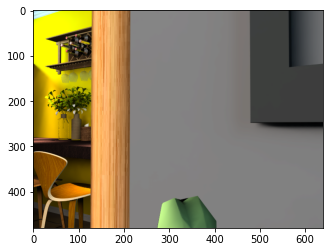

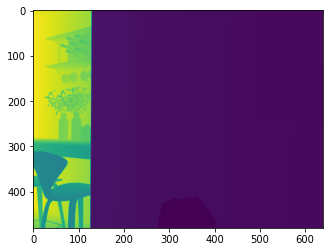

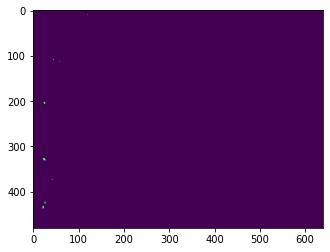

In [13]:
with torch.no_grad():
    for batch in loader:
        im, depth = batch['image'].to(device), batch['depth'].to(device)
        out = model(im)
        
#         print(out.mean())
#         acc = metrics(out, depth, st=(s,t) if st else None) # val_
#         print(acc)

        plt.imshow(im.squeeze(0).permute([1,2,0]).cpu())
        plt.show()
        plt.imshow(depth.squeeze(0).cpu())
        plt.show()
        plt.imshow(out.squeeze(0).cpu())
        plt.show()
        break